# script that quantifies how genes expression correlates with the insulation score

In [1]:
import pandas as pd
import numpy as np
import hicstraw 
from multiprocessing import Pool
from functools import partial
import glob
import os
import plotly.express as px
import math
import matplotlib.pyplot as plt
from matplotlib import colors
from pandarallel import pandarallel
import cooler
import cooltools
import pybedtools as pbed
pandarallel.initialize()
from scipy import stats, special
from statsmodels.stats import multitest
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.io as pio
import seaborn as sns
os.makedirs("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/", exist_ok = True)
pbed.helpers.set_tempdir("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/")
bed_genome_file = "/mnt/iusers01/jw01/mdefscs4/hg38.genome"

plt.rcParams['svg.fonttype'] = 'none'

base_dir = "/mnt/jw01-aruk-home01/projects/psa_functional_genomics/PsA_cleaned_analysis"

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
metadata_hic = pd.read_csv(f"{base_dir}/metadata/cleaned_HiC_metadata.csv", index_col = 0)

In [3]:
RNA_normalized_counts = pd.read_csv(f"{base_dir}/RNA_seq_analysis/RNA_normalized_counts.csv")
metadata_RNA = pd.read_csv(f"{base_dir}/metadata/cleaned_RNA_metadata.csv", index_col=0)
column_name_dict = dict(zip(metadata_RNA['sample'], metadata_RNA['proper_name']))
RNA_normalized_counts = RNA_normalized_counts.rename(columns=column_name_dict)
RNA_normalized_counts_melted = pd.melt(RNA_normalized_counts, id_vars=["ensembl","ENSG","symbol","genename","entrez"], 
        value_vars=RNA_normalized_counts.columns.difference(["ensembl","ENSG","symbol","genename","entrez"]),
        var_name="proper_name",value_name="expression")
RNA_normalized_counts_melted = RNA_normalized_counts_melted.merge(metadata_RNA[["patient","cell_type","condition","proper_name"]], on = "proper_name")

# RNA_normalized_counts_melted = RNA_normalized_counts_melted[RNA_normalized_counts_melted["cell_type"].isin(["CD4","CD8"])]

In [4]:
gtf_annotation_df = pd.read_pickle(f"{base_dir}/gencode_gtf.pickle")
gtf_transcripts = gtf_annotation_df[(gtf_annotation_df["feature"] == "transcript") & (gtf_annotation_df["transcript_type"] == "protein_coding")].dropna(axis=1, how='all')
gtf_transcripts["gene_id"] = gtf_transcripts["gene_id"].str.split(".").str[0]
gtf_transcripts["transcript_id"] = gtf_transcripts["transcript_id"].str.split(".").str[0]
gtf_transcripts["TSS_start"] = gtf_transcripts.apply(lambda x: int(x["start"]) if x["strand"] == "+" else int(x["end"]) ,axis = 1)
gtf_genes = gtf_annotation_df[(gtf_annotation_df["feature"] == "gene") & (gtf_annotation_df["gene_type"] == "protein_coding")].dropna(axis=1, how='all')
gtf_genes["gene_id"] = gtf_genes["gene_id"].str.split(".").str[0]
gtf_genes["TSS_start"] = gtf_genes.apply(lambda x: int(x["start"]) if x["strand"] == "+" else int(x["end"]) ,axis = 1)
gtf_genes["length"] = gtf_genes["end"].astype(int) - gtf_genes["start"].astype(int)

In [5]:
ins_scores = pd.read_csv(f"{base_dir}/HiC_analysis/insulation_score/aggregated_norm_ins_scores.csv.gz", index_col = 0)

In [6]:
column_name_dict = dict(zip(metadata_hic['folder_name'], metadata_hic['proper_name']))
ins_scores = ins_scores.rename(columns=column_name_dict)


In [7]:
ins_scores_melted = pd.melt(ins_scores, id_vars="chrom start end".split(), 
        value_vars=ins_scores.columns.difference("chrom start end".split()),
        var_name="sample",value_name="insulation")

In [8]:
RNA_diff = pd.read_csv("/mnt/jw01-aruk-home01/projects/psa_functional_genomics/PsA_combined_analysis/RNA_analysis/new_DE/DE_CD8_vs_CD4_all_lfc1.csv", index_col = 0)
RNA_diff["ENSG"] = RNA_diff.index.str.split(".").str[0]

In [9]:
all_corrs = []
for gene in RNA_diff[RNA_diff["padj"] < 0.1]["ENSG"].to_list():
    counts_gene = RNA_normalized_counts_melted[RNA_normalized_counts_melted["ENSG"] == gene].copy()
    # counts_gene = counts_gene[counts_gene["cell_type"] == "CD8"]
    if counts_gene["expression"].mean() > 10:
        try:
            gene_chrom = gtf_genes[gtf_genes["gene_id"] == gene].iloc[0]["seqname"]
            gene_tss = gtf_genes[gtf_genes["gene_id"] == gene].iloc[0]["TSS_start"]
        except:
            continue
        ins_score_TSS = ins_scores_melted[(ins_scores_melted["chrom"] == gene_chrom) & 
                      (ins_scores_melted["start"] < gene_tss) & 
                      (ins_scores_melted["end"] > gene_tss)].copy()
        if len(ins_score_TSS) > 1:
            merged = counts_gene.merge(ins_score_TSS, left_on = "proper_name", right_on = "sample")
            all_corrs.append(stats.pearsonr(merged["expression"], merged["insulation"])[0])

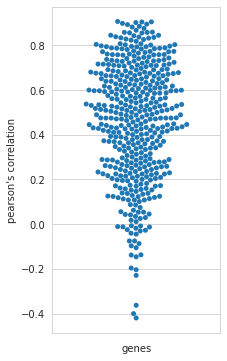

In [11]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1,1, figsize = (3,6), facecolor=(0, 0, 0, 0))
sns.swarmplot(y = all_corrs, ax = axes)
axes.set_xlabel("genes")
axes.set_ylabel("pearson's correlation")
fig.savefig(f"{base_dir}/integration_analysis/figures/ins_corr_RNA.png", dpi = 600)
fig.savefig(f"{base_dir}/integration_analysis/figures/ins_corr_RNA.svg", dpi = 600)